### 주제 선정 : ?

### 분석 배경 : 
최근 들어 'Scale 불량 발생 증가'라는 이슈가 발생했다. 그 원인을 분석해 본 결과 압연공정에서 Scale 불량이 급증한 것을 확인할 수 있었다. 불량 발생의 근본 원인을 찾고 결과를 해석하여 개선 기회를 도출한다.

### 분석 목적 :

### 예상 목표 :

### 분석 계획

탐색적 분석/전처리 - 모델링/요약 - 결론/개선방향 - 배운점


In [120]:
##패키지 불러오기

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl

import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score, roc_curve, auc

from sklearn.metrics import confusion_matrix

#경고창 제거
import warnings
warnings.filterwarnings('ignore')

#한글 적용
from matplotlib import font_manager, rc
import matplotlib.font_manager as fm
mpl.rc('font',family= 'Malgun Gothic')
font_manager.get_fontconfig_fonts()
fontname = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontname = font_manager.FontProperties(fname=fontname).get_name()
plt.style.use('seaborn-white')
rc('font', family=fontname)

## 1. 데이터 구성하기

In [58]:
df_raw = pd.read_csv("/home/pirl/Downloads/data2/SCALE불량.csv", encoding='CP949')
df_raw.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조


In [23]:
from IPython.display import Image

*데이터 설명*

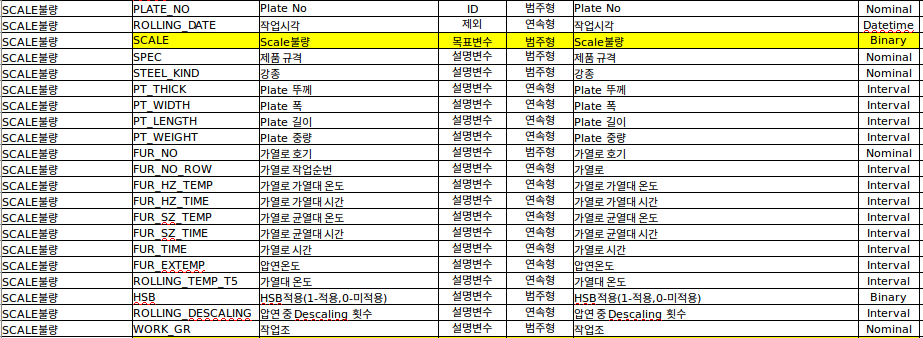

In [59]:
#결측치 확인
df_raw.isnull().sum()

PLATE_NO             0
ROLLING_DATE         0
SCALE                0
SPEC                 0
STEEL_KIND           0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64

결측치는 없음을 알 수 있다.

In [60]:
df_raw.shape

(720, 21)

In [61]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 21 columns):
PLATE_NO             720 non-null object
ROLLING_DATE         720 non-null object
SCALE                720 non-null object
SPEC                 720 non-null object
STEEL_KIND           720 non-null object
PT_THK               720 non-null float64
PT_WDTH              720 non-null int64
PT_LTH               720 non-null int64
PT_WGT               720 non-null int64
FUR_NO               720 non-null object
FUR_NO_ROW           720 non-null int64
FUR_HZ_TEMP          720 non-null int64
FUR_HZ_TIME          720 non-null int64
FUR_SZ_TEMP          720 non-null int64
FUR_SZ_TIME          720 non-null int64
FUR_TIME             720 non-null int64
FUR_EXTEMP           720 non-null int64
ROLLING_TEMP_T5      720 non-null int64
HSB                  720 non-null object
ROLLING_DESCALING    720 non-null int64
WORK_GR              720 non-null object
dtypes: float64(1), int64(12), object(8)
memo

In [62]:
df_raw.select_dtypes('object').apply(pd.Series.nunique, axis=0)

PLATE_NO        720
ROLLING_DATE    704
SCALE             2
SPEC             66
STEEL_KIND        9
FUR_NO            3
HSB               2
WORK_GR           4
dtype: int64

PLATE_NO, ROLLING_DATE 을 제거한다. (SCALE은 목표변수)

In [63]:
df_raw = df_raw.drop(['PLATE_NO', 'ROLLING_DATE'],axis=1)
df_raw.head()

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1133,934,적용,8,2조
1,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1135,937,적용,8,2조
2,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1121,889,적용,8,3조
3,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1127,885,적용,8,3조
4,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1128,873,적용,8,1조


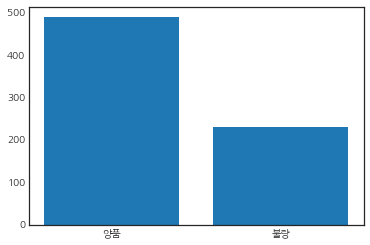

In [109]:
#목표변수에 대한 막대차트
scale = df_raw['SCALE'].value_counts()
plt.bar(scale.index, scale)
plt.show()

### 범주형 자료에 대한 막대차트

* SPEC : 제품 규격
* STEEL_KIND : 강종
* FUR_NO : 가열로 호기
* HSB : HSB 적용 유무
* WORK_GR : 작업조

In [37]:
#범주형 자료에 대한 막대차트
def bar_chart(feature) :
    good = df_raw[df_raw['SCALE']=='양품'][feature].value_counts()
    bad = df_raw[df_raw['SCALE']=='불량'][feature].value_counts()
    df = pd.DataFrame([good, bad])
    df.index =['양품', '불량']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

*SPEC 은 자료의 수가 많기 때문에 비교하기 어려우므로 생략*

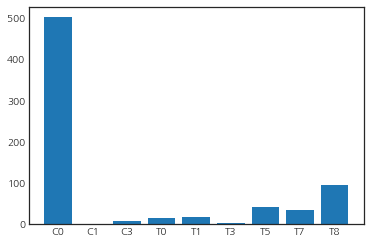

In [96]:
#STEEL_KIND : 강종
SK = df_raw['STEEL_KIND'].value_counts().sort_index()
plt.bar(SK.index,SK)
plt.show()

강종은 C0, T8, T5 순으로 많음을 볼 수 있다.

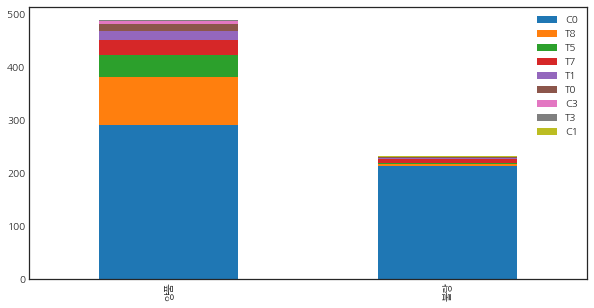

In [92]:
bar_chart('STEEL_KIND')

C0은 양품이 많지만 불량도 많음을 알 수 있고, T8의 경우 양품대비 불량의 수가 비교적 적음을 알 수 있다.

<function matplotlib.pyplot.show(*args, **kw)>

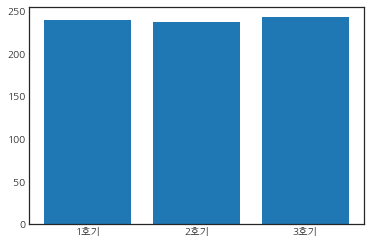

In [97]:
#FUR_NO : 가열로 호기
FN = df_raw['FUR_NO'].value_counts().sort_index()
plt.bar(FN.index, FN)
plt.show

가열로의 호기에서 생상되는 양에는 큰 차이가 없다.

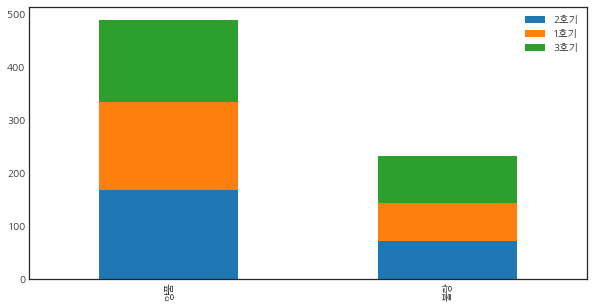

In [95]:
bar_chart('FUR_NO')

각각 양품과 불량을 생산하는 것에 큰 차이는 없다.

<function matplotlib.pyplot.show(*args, **kw)>

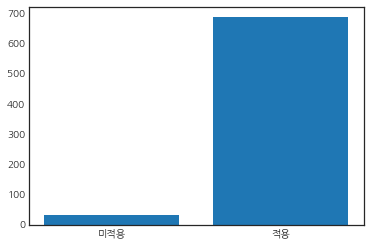

In [98]:
#HSB : HSB 적용 유무 (1-적용, 0-미적용)
HSB = df_raw['HSB'].value_counts().sort_index()
plt.bar(HSB.index, HSB)
plt.show

In [99]:
#적용과 미적용의 차이가 나므로 수치로 확인해본다.
print(HSB)

미적용     33
적용     687
Name: HSB, dtype: int64


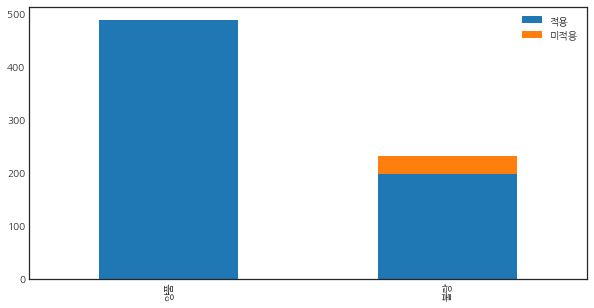

In [100]:
bar_chart('HSB')

HSB를 미적용한 경우는 100% 불량이 나왔음을 알 수 있다.

<function matplotlib.pyplot.show(*args, **kw)>

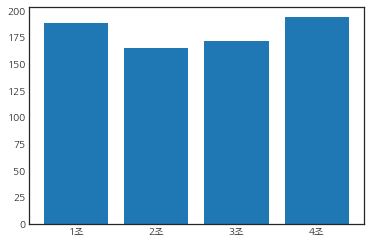

In [101]:
#WORK_GR : 작업조
WG = df_raw['WORK_GR'].value_counts().sort_index()
plt.bar(WG.index, WG)
plt.show

In [102]:
print(WG)

1조    189
2조    165
3조    172
4조    194
Name: WORK_GR, dtype: int64


생산량은 4조, 1조, 3조, 2조 순으로 많음을 알 수 있다.

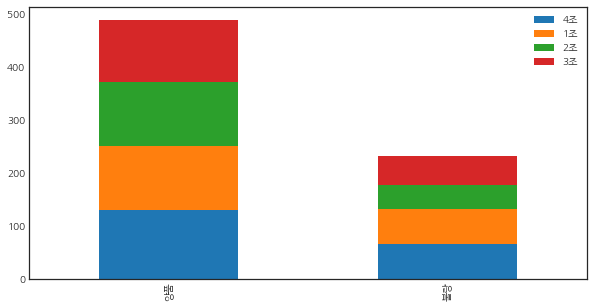

In [104]:
bar_chart('WORK_GR')

생산조에 따른 양품과 불량에 대한 차이는 거의 없어 보인다.

### 연속형 자료
* PT_THK : Plate 두께
* PT_WDTH : Plate 폭
* PT_LTH : Plate 길이
* PT_WGT : Plate 중량
* FUR_NO_ROW :가열로 작업순번
* FUR_HZ_TEMP : 가열로 가열대 온도
* FUR_HZ_TIME : 가열로 가열대 시간
* FUR_SZ_TEMP : 가열로 균열대 온도
* FUR_SZ_TIME : 가열로 균일대 시간
* FUR_TIME : 가열로 시간
* FUR_EXTEMP : 압연 온도
* ROLLING_TEMP_T5 : 가열대 온도
* ROLLING_DESCALING : 압연 중 Descaling 횟수

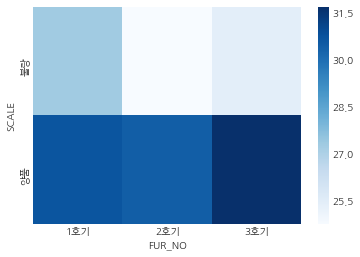

In [138]:
#scale 불량여부,가열로 호기별 plate 두께 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','FUR_NO'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','FUR_NO','PT_THK')
sns.heatmap(df_pivot, cmap="Blues")

양품일수록 철판의 두께가 두꺼움을 알 수 있다.

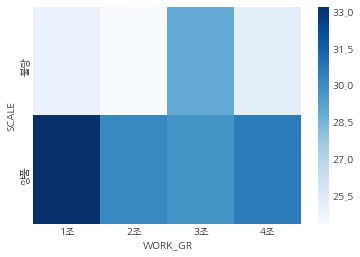

In [139]:
#scale 불량여부, 작업조별 plate 두께 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','WORK_GR'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','WORK_GR','PT_THK')
sns.heatmap(df_pivot, cmap="Blues")

양품일수록 철판의 두께가 두거움을 알 수 있다. 3조에서 생산하는 철판의 두께는 양품과 불량사이에 큰 차이가 없다.

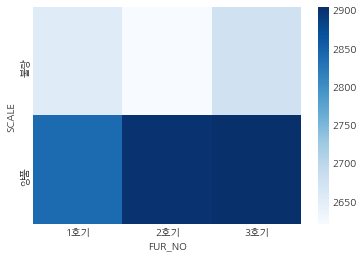

In [140]:
#scale 불량여부,가열로 호기별 plate 폭 평균 계산 : 히트맵

df_plate_wdth = df_raw.groupby(['SCALE','FUR_NO'], as_index=False).agg('mean')
df_pivot = df_plate_wdth.pivot('SCALE','FUR_NO','PT_WDTH')
sns.heatmap(df_pivot, cmap="Blues")

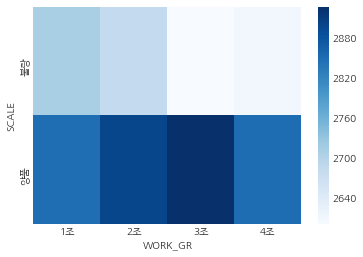

In [141]:
#scale 불량여부, 작업조별 plate 폭 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','WORK_GR'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','WORK_GR','PT_WDTH')
sns.heatmap(df_pivot, cmap="Blues")

양품일수록 철판의 폭이 큼을 알 수 있다.

### 상자그림

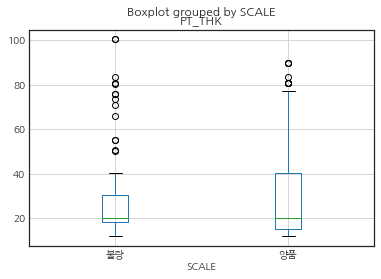

In [142]:
#1. PT_THK
df_raw.boxplot(column='PT_THK', by='SCALE')

In [147]:
#양품과 불량품의 철판 두께에 차이가 있는지 검정 : 2-sample t-test
df1 = df_raw[df_raw['SCALE']=='불량']['PT_THK']
df2 = df_raw[df_raw['SCALE']=='양품']['PT_THK']

t_result = stats.ttest_ind(df1, df2)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print('[2-sample t test]')
print('\nt검정통계량 : %.3f' %t)
print('p-value : %.3f' %p)

[2-sample t test]

t검정통계량 : -3.372
p-value : 0.001
